# Assignment 2: Convolution
# BA 64061-003
# Madeline Witzeman

# First step: Loading the Cats and Dogs dataset

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"madelinewitzeman","key":"c16acb09f2ea0802d6bca05022ea6f66"}'}

In [2]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle competitions download -c dogs-vs-cats

 99% 804M/812M [00:03<00:00, 262MB/s]
100% 812M/812M [00:03<00:00, 216MB/s]


In [4]:
!unzip -qq dogs-vs-cats.zip

In [5]:
!unzip -qq train.zip

## Copying images to training, validation, and test directories

In [6]:
import os, shutil, pathlib

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train", start_index=667, end_index=1667)
make_subset("validation", start_index=1668, end_index=2168)
make_subset("test", start_index=2169, end_index=2669)

# Next Step: Building the Initial Model for Problem #1 (Training Model from Scratch)

## Setting up small initial convnet for dogs vs. cats classification

In [7]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [8]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 89, 89, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 43, 43, 64)        0         
 g2D)                                                        

## Configuring the model for training

In [9]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

I'm initially establishing a model with an alternating stack of Conv2D and MaxPooling2D layers -- the model needs to also reduce the size of the feature maps enough prior to the Flatten layer. Additionally, since this is a binary-classification problem, I ended the model with a single Dense layer (size of '1') with sigmoid activation. Lastly, I utilized the RMPprop optimizer since it's a standard choice and binary crossentropy as the loss function since the final layer is a single sigmoid unit.

## Data Preprocessing: Using image_dataset_from_directory to read images

In [10]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


Checking the shapes of data batches and labels:

In [11]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


The data needed to be formatted into tensors prior to being fed into the convnet.

## Fitting the model, saving only the best model according to the validation loss after each epoch

In [12]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 7s 34ms/step - loss: 0.6984 - accuracy: 0.4965 - val_loss: 0.6900 - val_accuracy: 0.6090
Epoch 2/30
63/63 [==============================] - 1s 21ms/step - loss: 0.6887 - accuracy: 0.5420 - val_loss: 0.7918 - val_accuracy: 0.5000
Epoch 3/30
63/63 [==============================] - 1s 23ms/step - loss: 0.6763 - accuracy: 0.5940 - val_loss: 0.6681 - val_accuracy: 0.5940
Epoch 4/30
63/63 [==============================] - 1s 23ms/step - loss: 0.6490 - accuracy: 0.6230 - val_loss: 0.6586 - val_accuracy: 0.6070
Epoch 5/30
63/63 [==============================] - 1s 22ms/step - loss: 0.6358 - accuracy: 0.6420 - val_loss: 0.6271 - val_accuracy: 0.6570
Epoch 6/30
63/63 [==============================] - 1s 22ms/step - loss: 0.5990 - accuracy: 0.6745 - val_loss: 0.5934 - val_accuracy: 0.6830
Epoch 7/30
63/63 [==============================] - 1s 22ms/step - loss: 0.5838 - accuracy: 0.7150 - val_loss: 0.6625 - val_accuracy: 0.6580
Epoch 8/30
63

## Displaying curves of loss and accuracy during training

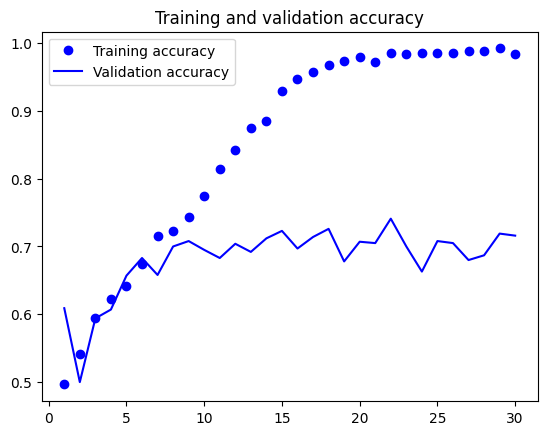

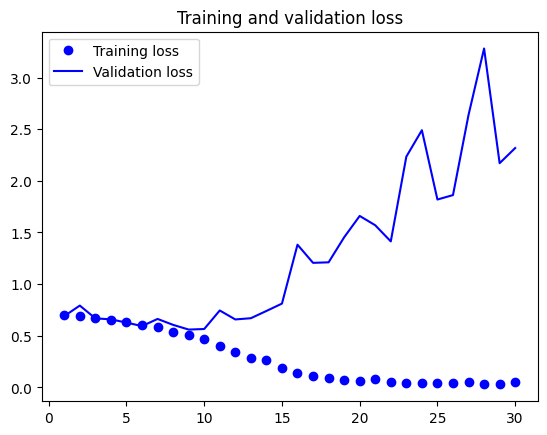

In [13]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

## Evaluating the accuracy of the model on the test dataset

In [14]:
test_model = keras.models.load_model("convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 1s 11ms/step - loss: 0.5398 - accuracy: 0.7340
Test accuracy: 0.734


The plots above indicate that the current model is overfitting. Validation accuracy only hits ~70%-75% at most, and the validation loss increases as the number of epochs continues to grow beyond 10. Additionally, the test accuracy is only ~70%. (Used average based on 3 runs to establish solid baseline to compare against -- accuracy metrics will vary some due to stochastic learning of the model)

-Run 1: 71.1%
-Run 2: 65.7%
-Run 3: 72.2%

To address the overfitting in the current model, I'm going to employ data augmentation and dropout and see how it affects the validation and test accuracies.

# Problem #1 Continued: Utilizing Data Augmentation and Dropout to Reduce Overfitting and Improve Performance of Initial Model

## Defining data augmentation stage to apply in convnet model

In [15]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

## Defining a new convnet that includes image augmentation and dropout

In [16]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

Since the initial training sample size is relatively small, the model is overfitting early in training. Data augmentation helps mitigate the effects of a small training sample size by essentially generating more training data: it allows the model to learn more aspects of the existing data. The input data will now be randomly flipped horizontally, randomly rotated -36 degrees to +36 degrees, and randomly zoomed in/out somewhere within the range of -20% to +20%. Utilizing dropout also helps mitigate overfitting, as just data augmentation alone may not be enough.

## Training new convnet (data augmentation + dropout)

In [17]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/100
63/63 [==============================] - 4s 27ms/step - loss: 0.6956 - accuracy: 0.4860 - val_loss: 0.6926 - val_accuracy: 0.5000
Epoch 2/100
63/63 [==============================] - 2s 23ms/step - loss: 0.6935 - accuracy: 0.5310 - val_loss: 0.6952 - val_accuracy: 0.5000
Epoch 3/100
63/63 [==============================] - 2s 25ms/step - loss: 0.6858 - accuracy: 0.5590 - val_loss: 0.6742 - val_accuracy: 0.6200
Epoch 4/100
63/63 [==============================] - 2s 24ms/step - loss: 0.6778 - accuracy: 0.5915 - val_loss: 0.6392 - val_accuracy: 0.6480
Epoch 5/100
63/63 [==============================] - 2s 25ms/step - loss: 0.6576 - accuracy: 0.6290 - val_loss: 0.7086 - val_accuracy: 0.5470
Epoch 6/100
63/63 [==============================] - 2s 25ms/step - loss: 0.6608 - accuracy: 0.6220 - val_loss: 0.5944 - val_accuracy: 0.6890
Epoch 7/100
63/63 [==============================] - 2s 25ms/step - loss: 0.6275 - accuracy: 0.6415 - val_loss: 0.5661 - val_accuracy: 0.7110
Epoch 

## Displaying curves of loss and accuracy during training

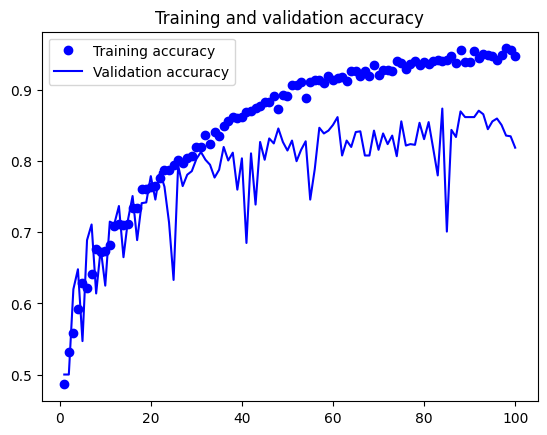

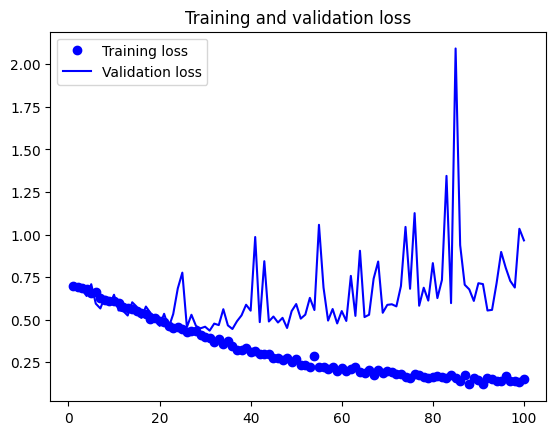

In [18]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

## Evaluating the accuracy of the model on the test dataset

In [19]:
test_model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 1s 9ms/step - loss: 0.4281 - accuracy: 0.8060
Test accuracy: 0.806


After including data augmentation and droupout in the initial model, the validation accuracy increased to ~80-85% at most and the test accuracy increased significantly to ~79-83%. (Again, accuracy metrics will vary some due to stochastic learning of the model).

Using data augmentation and dropout significantly improved model performance.

# Problem #2: Increasing Training Sample Size and Training New Model from Scratch

## Increasing training sample size from 1,000 to 3,000 images & copying images to training, validation, and test directories

In [20]:
import os, shutil, pathlib

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train2", start_index=667, end_index=3667)
make_subset("validation2", start_index=3668, end_index=4168)
make_subset("test2", start_index=4169, end_index=4669)

# Building the Initial Model for Problem #2 (Training Model from Scratch)

## Setting up initial convnet based on larger training sample

In [21]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [22]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_10 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 89, 89, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 43, 43, 64)        0         
 g2D)                                                      

## Data Preprocessing: Using image_dataset_from_directory to read images

In [23]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset2 = image_dataset_from_directory(
    new_base_dir / "train2",
    image_size=(180, 180),
    batch_size=32)
validation_dataset2 = image_dataset_from_directory(
    new_base_dir / "validation2",
    image_size=(180, 180),
    batch_size=32)
test_dataset2 = image_dataset_from_directory(
    new_base_dir / "test2",
    image_size=(180, 180),
    batch_size=32)

Found 6000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [24]:
for data_batch, labels_batch in train_dataset2:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


## Fitting the model, saving only the best model according to the validation loss after each epoch

In [25]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch2.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset2,
    epochs=30,
    validation_data=validation_dataset2,
    callbacks=callbacks)

Epoch 1/30
188/188 [==============================] - 5s 19ms/step - loss: 0.6951 - accuracy: 0.5260 - val_loss: 0.6927 - val_accuracy: 0.5110
Epoch 2/30
188/188 [==============================] - 4s 18ms/step - loss: 0.6540 - accuracy: 0.6240 - val_loss: 0.6131 - val_accuracy: 0.6490
Epoch 3/30
188/188 [==============================] - 4s 18ms/step - loss: 0.5945 - accuracy: 0.6813 - val_loss: 0.5507 - val_accuracy: 0.7140
Epoch 4/30
188/188 [==============================] - 3s 18ms/step - loss: 0.5485 - accuracy: 0.7240 - val_loss: 0.5680 - val_accuracy: 0.7320
Epoch 5/30
188/188 [==============================] - 3s 17ms/step - loss: 0.4912 - accuracy: 0.7600 - val_loss: 0.5949 - val_accuracy: 0.7100
Epoch 6/30
188/188 [==============================] - 3s 18ms/step - loss: 0.4379 - accuracy: 0.7970 - val_loss: 0.4622 - val_accuracy: 0.7970
Epoch 7/30
188/188 [==============================] - 3s 18ms/step - loss: 0.3869 - accuracy: 0.8263 - val_loss: 0.5441 - val_accuracy: 0.7460

## Displaying curves of loss and accuracy during training

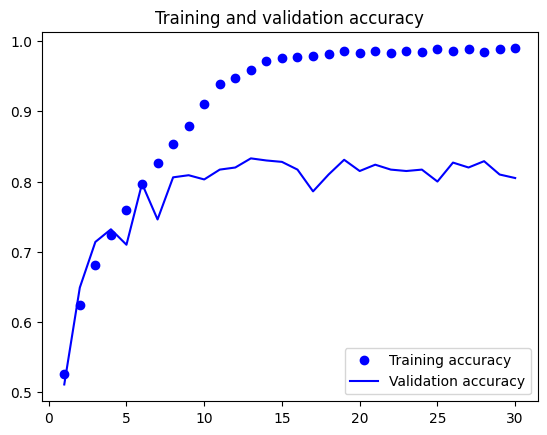

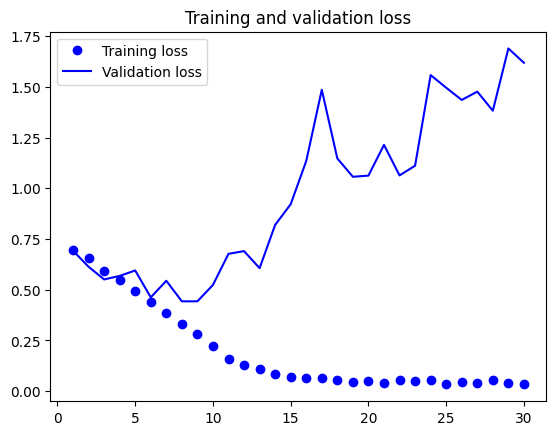

In [26]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

## Evaluating the accuracy of the model on the test dataset

In [27]:
test_model = keras.models.load_model("convnet_from_scratch2.keras")
test_loss, test_acc = test_model.evaluate(test_dataset2)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 1s 10ms/step - loss: 0.4206 - accuracy: 0.8170
Test accuracy: 0.817


The plots above indicate that increasing the training sample size from 1,000 images to 3,000 images improved performance: validation accuracy now hits around 78%-82%, and the test accuracy is also ~78%-82%. (Accuracy metrics will vary some due to stochastic learning of the model).

However, there appears to be overfitting again. I'm going to see if I can improve model performance and reduce overfitting by employing data augmentation and dropout.

# Problem #2 Continued: Adding Data Augmentation and Dropout

## Defining data augmentation stage to apply in convnet model

In [28]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

## Defining a new convnet that includes image augmentation and dropout

In [29]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

## Training new convnet (data augmentation + dropout)

In [30]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation2.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset2,
    epochs=100,
    validation_data=validation_dataset2,
    callbacks=callbacks)

Epoch 1/100
188/188 [==============================] - 6s 21ms/step - loss: 0.6988 - accuracy: 0.5088 - val_loss: 0.6896 - val_accuracy: 0.5940
Epoch 2/100
188/188 [==============================] - 4s 20ms/step - loss: 0.6815 - accuracy: 0.5737 - val_loss: 0.6519 - val_accuracy: 0.6310
Epoch 3/100
188/188 [==============================] - 4s 19ms/step - loss: 0.6459 - accuracy: 0.6352 - val_loss: 0.6368 - val_accuracy: 0.6280
Epoch 4/100
188/188 [==============================] - 4s 20ms/step - loss: 0.6112 - accuracy: 0.6740 - val_loss: 0.5554 - val_accuracy: 0.7270
Epoch 5/100
188/188 [==============================] - 4s 20ms/step - loss: 0.5789 - accuracy: 0.7033 - val_loss: 0.6301 - val_accuracy: 0.6380
Epoch 6/100
188/188 [==============================] - 4s 20ms/step - loss: 0.5621 - accuracy: 0.7183 - val_loss: 0.4951 - val_accuracy: 0.7630
Epoch 7/100
188/188 [==============================] - 4s 20ms/step - loss: 0.5414 - accuracy: 0.7278 - val_loss: 0.5372 - val_accuracy:

## Displaying curves of loss and accuracy during training

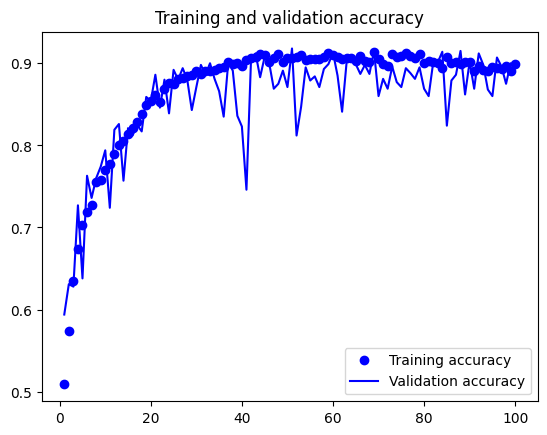

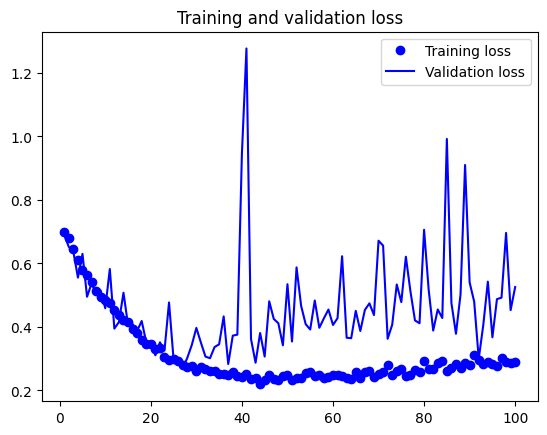

In [31]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

## Evaluating the accuracy of the model on the test dataset

In [32]:
test_model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation2.keras")
test_loss, test_acc = test_model.evaluate(test_dataset2)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 1s 9ms/step - loss: 0.2484 - accuracy: 0.8980
Test accuracy: 0.898


After both increasing the training sample size to 3,000 images and using data augmentation and dropout, model performance improved significantly: the validation accuracy is ~90%-92% at most and the test accuracy is ~89%-92% (with some variation). One thing to note -- there is an interesting pattern displayed on the training and validation accuracy plot where the validation accuracy closely follows the training accuracy and even surpasses it in some instances.

Since the initial models for a training sample size of 1,000 images and 3,000 images were indicating overfitting, I'm going to automatically utilize data augmentation and dropout moving forward when generating new models and assessing performance.

# Problem #3: Adjusting Training Sample Size Again and Training New Models from Scratch to Achieve Best Performance

## Increasing Training Sample Size from 3,000 to 5,000 images & copying images to training, validation, and test directories

In [33]:
import os, shutil, pathlib

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train3", start_index=667, end_index=5667)
make_subset("validation3", start_index=5668, end_index=6168)
make_subset("test3", start_index=6169, end_index=6669)

## Data Preprocessing: Using image_dataset_from_directory to read images

In [34]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset3 = image_dataset_from_directory(
    new_base_dir / "train3",
    image_size=(180, 180),
    batch_size=32)
validation_dataset3 = image_dataset_from_directory(
    new_base_dir / "validation3",
    image_size=(180, 180),
    batch_size=32)
test_dataset3 = image_dataset_from_directory(
    new_base_dir / "test3",
    image_size=(180, 180),
    batch_size=32)

Found 10000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [35]:
for data_batch, labels_batch in train_dataset3:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


## Defining data augmentation stage to apply in convnet model

In [36]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

## Defining a new convnet that includes image augmentation and dropout

In [37]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

## Training new convnet (data augmentation + dropout + larger training sample)

In [38]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation3.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset3,
    epochs=100,
    validation_data=validation_dataset3,
    callbacks=callbacks)

Epoch 1/100
313/313 [==============================] - 8s 20ms/step - loss: 0.7043 - accuracy: 0.5256 - val_loss: 0.6748 - val_accuracy: 0.6200
Epoch 2/100
313/313 [==============================] - 6s 19ms/step - loss: 0.6514 - accuracy: 0.6268 - val_loss: 0.6311 - val_accuracy: 0.6540
Epoch 3/100
313/313 [==============================] - 6s 20ms/step - loss: 0.5928 - accuracy: 0.6932 - val_loss: 0.5538 - val_accuracy: 0.7060
Epoch 4/100
313/313 [==============================] - 6s 19ms/step - loss: 0.5487 - accuracy: 0.7269 - val_loss: 0.4909 - val_accuracy: 0.7680
Epoch 5/100
313/313 [==============================] - 6s 19ms/step - loss: 0.5126 - accuracy: 0.7463 - val_loss: 0.4671 - val_accuracy: 0.7740
Epoch 6/100
313/313 [==============================] - 6s 20ms/step - loss: 0.4856 - accuracy: 0.7634 - val_loss: 0.4128 - val_accuracy: 0.8130
Epoch 7/100
313/313 [==============================] - 6s 19ms/step - loss: 0.4612 - accuracy: 0.7859 - val_loss: 0.3983 - val_accuracy:

## Displaying curves of loss and accuracy during training

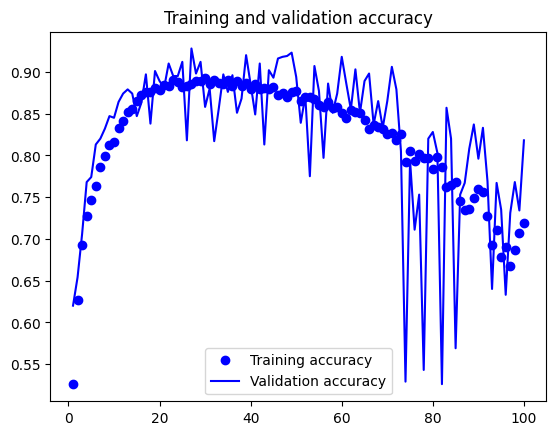

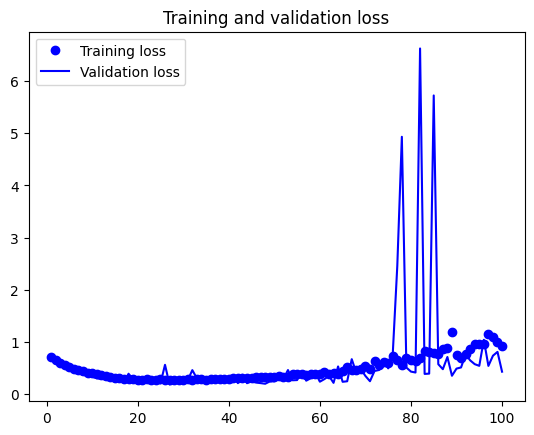

In [39]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

## Evaluating the accuracy of the model on the test dataset

In [40]:
test_model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation3.keras")
test_loss, test_acc = test_model.evaluate(test_dataset3)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 1s 10ms/step - loss: 0.1764 - accuracy: 0.9190
Test accuracy: 0.919


Increasing the training sample size to 5,000 images slightly increases the validation accuracy to ~91%-94% at most and keeps the test accuracy to ~90%-92% (with some variation).

However, there are some odd/concerning trends depicted on the training and validation accuracy and loss plots. Both training and validation accuracy start dropping after ~35 epochs. Having the training accuracy drop as the model continues to train is the opposite of what I'd expect. Based on my research, it seems this may be related to using the rmsprop optimizer or the training rate, but I'm not entirely sure. Additionally, the validation accuracy is actually above the training accuracy across several epochs. I'm also not sure the exact reason for this, but am wondering if the validation dataset may be too small compared to the larger training dataset and therefore this is something happening by chance. Lastly, it's interesting that both validation and test loss are low throughout training, with the exceptions of a few data points where the validation loss spikes.

Given the odd trends displayed on the training and validation accuracy and loss plots, I am considering the model that used 3,000 training images and image augmentation + dropout to be the best model so far.


# Problem #3 Continued: Decreasing the training sample size

## Decreasing Training Sample Size to 2,000 images & copying images to training, validation, and test directories

Since the training sample size of 3,000 images achieved better perfomance than a training sample size of 1,000, I'm going to see if a training sample size of 2,000 images is a "sweet spot" and somehow better than a training sample size of 3,000 or 5,000.

In [41]:
import os, shutil, pathlib

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train4", start_index=667, end_index=2667)
make_subset("validation4", start_index=2668, end_index=3168)
make_subset("test4", start_index=3169, end_index=3669)

## Data Preprocessing: Using image_dataset_from_directory to read images

In [42]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset4 = image_dataset_from_directory(
    new_base_dir / "train4",
    image_size=(180, 180),
    batch_size=32)
validation_dataset4 = image_dataset_from_directory(
    new_base_dir / "validation4",
    image_size=(180, 180),
    batch_size=32)
test_dataset4 = image_dataset_from_directory(
    new_base_dir / "test4",
    image_size=(180, 180),
    batch_size=32)

Found 4000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [43]:
for data_batch, labels_batch in train_dataset4:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


## Defining data augmentation stage to apply in convnet model

In [44]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

## Defining a new convnet that includes image augmentation and dropout

In [45]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

## Training new convnet (data augmentation + dropout + larger training sample)

In [46]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation4.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset4,
    epochs=100,
    validation_data=validation_dataset4,
    callbacks=callbacks)

Epoch 1/100
125/125 [==============================] - 5s 23ms/step - loss: 0.7004 - accuracy: 0.5013 - val_loss: 0.6914 - val_accuracy: 0.5540
Epoch 2/100
125/125 [==============================] - 3s 22ms/step - loss: 0.6952 - accuracy: 0.5242 - val_loss: 0.6874 - val_accuracy: 0.5030
Epoch 3/100
125/125 [==============================] - 3s 23ms/step - loss: 0.6767 - accuracy: 0.5707 - val_loss: 0.6466 - val_accuracy: 0.6080
Epoch 4/100
125/125 [==============================] - 3s 22ms/step - loss: 0.6445 - accuracy: 0.6320 - val_loss: 0.6180 - val_accuracy: 0.6530
Epoch 5/100
125/125 [==============================] - 3s 21ms/step - loss: 0.6324 - accuracy: 0.6345 - val_loss: 0.6157 - val_accuracy: 0.6610
Epoch 6/100
125/125 [==============================] - 3s 22ms/step - loss: 0.6113 - accuracy: 0.6660 - val_loss: 0.6126 - val_accuracy: 0.6760
Epoch 7/100
125/125 [==============================] - 3s 21ms/step - loss: 0.5887 - accuracy: 0.6873 - val_loss: 0.5851 - val_accuracy:

## Displaying curves of loss and accuracy during training

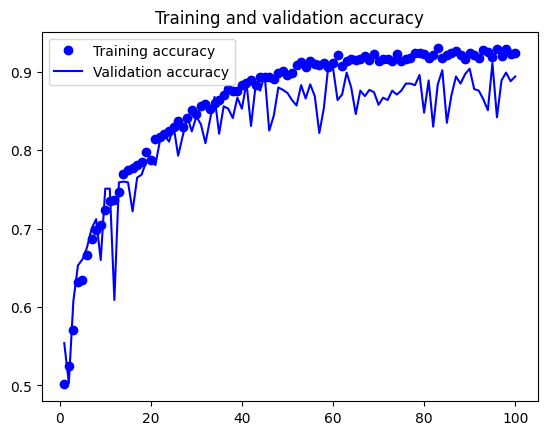

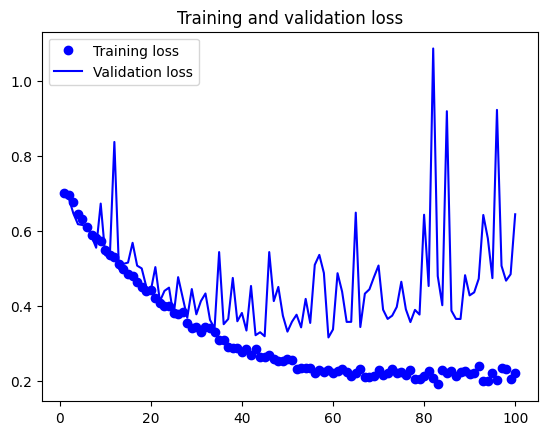

In [47]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

## Evaluating the accuracy of the model on the test dataset

In [48]:
test_model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation4.keras")
test_loss, test_acc = test_model.evaluate(test_dataset4)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 1s 10ms/step - loss: 0.3226 - accuracy: 0.9010
Test accuracy: 0.901


Using a training sample size of 2,000 images resulted in a validation accuracy of ~87%-91% at best and a test accuracy of ~90%-92%. This is very similar to the model with a training sample of 3,000 images (and data augmentation + dropout), but the model using 3,000 images for training appears to be slightly better.

# Problem #4: Repeat Problems 1 - 3 using a Pretrained Network

## Establishing the VGG16 convolutional base

In [49]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

58889256/58889256 [==============================] - 0s 0us/step


In [50]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

I chose to utilize the VGG16 convolutional base since it was trained using animal pictures (several cats and dogs) from ImageNet.

## Extracting the VGG16 features and corresponding labels

In [51]:
import numpy as np

def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)

1/1 [==============================] - 0s 22ms/step


In [52]:
train_features.shape

(2000, 5, 5, 512)

## Defining and training the densely connected classifier, starting with training sample of 1,000, validation sample of 500, and test sample of 500 + dropout for regularization

In [53]:
inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
      filepath="feature_extraction.keras",
      save_best_only=True,
      monitor="val_loss")
]
history = model.fit(
    train_features, train_labels,
    epochs=20,
    validation_data=(val_features, val_labels),
    callbacks=callbacks)

Epoch 1/20
63/63 [==============================] - 1s 10ms/step - loss: 13.6661 - accuracy: 0.9315 - val_loss: 4.8325 - val_accuracy: 0.9620
Epoch 2/20
63/63 [==============================] - 0s 7ms/step - loss: 4.8587 - accuracy: 0.9690 - val_loss: 2.4498 - val_accuracy: 0.9810
Epoch 3/20
63/63 [==============================] - 0s 5ms/step - loss: 0.7669 - accuracy: 0.9910 - val_loss: 3.8829 - val_accuracy: 0.9740
Epoch 4/20
63/63 [==============================] - 0s 5ms/step - loss: 1.4580 - accuracy: 0.9890 - val_loss: 3.1220 - val_accuracy: 0.9790
Epoch 5/20
63/63 [==============================] - 0s 5ms/step - loss: 0.5153 - accuracy: 0.9950 - val_loss: 4.3443 - val_accuracy: 0.9760
Epoch 6/20
63/63 [==============================] - 0s 5ms/step - loss: 0.5881 - accuracy: 0.9920 - val_loss: 7.4719 - val_accuracy: 0.9650
Epoch 7/20
63/63 [==============================] - 0s 5ms/step - loss: 0.6324 - accuracy: 0.9935 - val_loss: 4.4489 - val_accuracy: 0.9730
Epoch 8/20
63/63 [

## Displaying curves of loss and accuracy during training

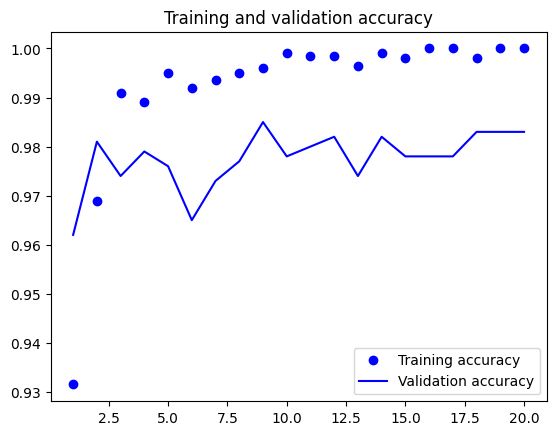

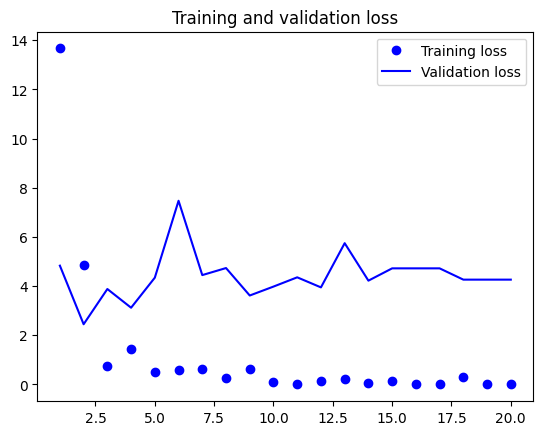

In [54]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

Using a pretrained network with dropout (and no data augmentation) noticeably improves performance: the validation accuracy increased to ~98%. The test accuracy can't be computed yet because the shape of the test dataset isn't the same as the pretrained network shape.

# Problem #4 Continued: Utilizing Data Augmentation in Pretrained Network to Reduce Overfitting and Improve Performance of Initial Model (Still using Feature Extraction)

## Establishing and freezing the VGG16 convolutional base

In [55]:
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)
conv_base.trainable = False

## Printing the list of trainable weights before and after freezing

In [56]:
conv_base.trainable = True
print("This is the number of trainable weights "
      "before freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights before freezing the conv base: 26


In [57]:
conv_base.trainable = False
print("This is the number of trainable weights "
      "after freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights after freezing the conv base: 0


## Adding a data augmentation stage and a classifier to the initial convolutional base

In [58]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [59]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction_with_data_augmentation",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/50
63/63 [==============================] - 7s 96ms/step - loss: 18.3967 - accuracy: 0.8985 - val_loss: 13.0891 - val_accuracy: 0.9210
Epoch 2/50
63/63 [==============================] - 6s 102ms/step - loss: 6.5697 - accuracy: 0.9400 - val_loss: 3.8640 - val_accuracy: 0.9720
Epoch 3/50
63/63 [==============================] - 6s 93ms/step - loss: 4.5462 - accuracy: 0.9595 - val_loss: 3.0294 - val_accuracy: 0.9780
Epoch 4/50
63/63 [==============================] - 3s 51ms/step - loss: 5.4683 - accuracy: 0.9595 - val_loss: 3.9402 - val_accuracy: 0.9790
Epoch 5/50
63/63 [==============================] - 6s 102ms/step - loss: 4.0129 - accuracy: 0.9635 - val_loss: 2.5830 - val_accuracy: 0.9810
Epoch 6/50
63/63 [==============================] - 3s 50ms/step - loss: 4.1766 - accuracy: 0.9680 - val_loss: 2.6511 - val_accuracy: 0.9820
Epoch 7/50
63/63 [==============================] - 6s 94ms/step - loss: 2.9740 - accuracy: 0.9690 - val_loss: 1.7336 - val_accuracy: 0.9800
Epoch 8/5

## Displaying curves of loss and accuracy during training

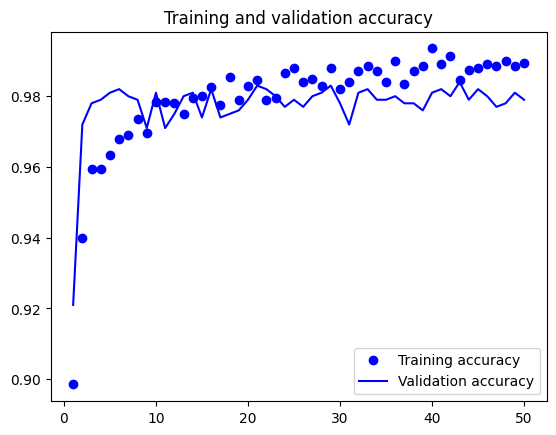

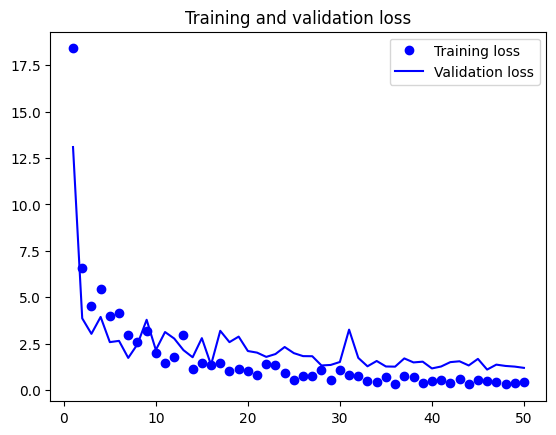

In [60]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

## Evaluating the accuracy of the model on the test dataset

In [61]:
test_model = keras.models.load_model(
    "feature_extraction_with_data_augmentation")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 1s 31ms/step - loss: 2.7574 - accuracy: 0.9660
Test accuracy: 0.966


Using a pretrained network with both dropout and data augmentation results in a validation accuracy of ~98% and a test accuracy of ~96%-98%. This is a significant improvement in performance over any of the networks trained from scratch in problems 1 - 3. Given this increase in model performance, I'm going to utlize dropout + data augmentation in the pretrained networks moving forward.

# Problem #4 Cont: Increasing Training Sample Size to 3,000 images (Still Using Feature Extraction)

## Establishing and freezing the VGG16 convolutional base

In [62]:
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)
conv_base.trainable = False

## Adding a data augmentation stage and a classifier to the initial convolutional base; reference correct training/validation/test datasets

In [63]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [64]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction_with_data_augmentation2",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset2,
    epochs=50,
    validation_data=validation_dataset2,
    callbacks=callbacks)

Epoch 1/50
188/188 [==============================] - 11s 53ms/step - loss: 11.2813 - accuracy: 0.9228 - val_loss: 5.0438 - val_accuracy: 0.9720
Epoch 2/50
188/188 [==============================] - 7s 39ms/step - loss: 6.0055 - accuracy: 0.9500 - val_loss: 6.4408 - val_accuracy: 0.9710
Epoch 3/50
188/188 [==============================] - 10s 55ms/step - loss: 3.9157 - accuracy: 0.9580 - val_loss: 3.5293 - val_accuracy: 0.9800
Epoch 4/50
188/188 [==============================] - 7s 39ms/step - loss: 2.3339 - accuracy: 0.9662 - val_loss: 4.4167 - val_accuracy: 0.9690
Epoch 5/50
188/188 [==============================] - 10s 53ms/step - loss: 1.9945 - accuracy: 0.9648 - val_loss: 2.8467 - val_accuracy: 0.9770
Epoch 6/50
188/188 [==============================] - 11s 56ms/step - loss: 1.3365 - accuracy: 0.9660 - val_loss: 2.4901 - val_accuracy: 0.9750
Epoch 7/50
188/188 [==============================] - 10s 53ms/step - loss: 1.0500 - accuracy: 0.9643 - val_loss: 1.6495 - val_accuracy: 

## Displaying curves of loss and accuracy during training

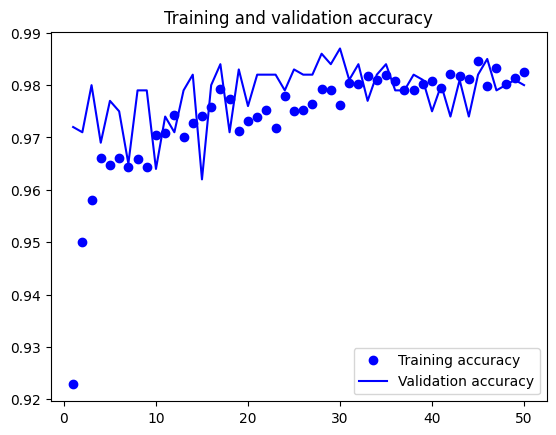

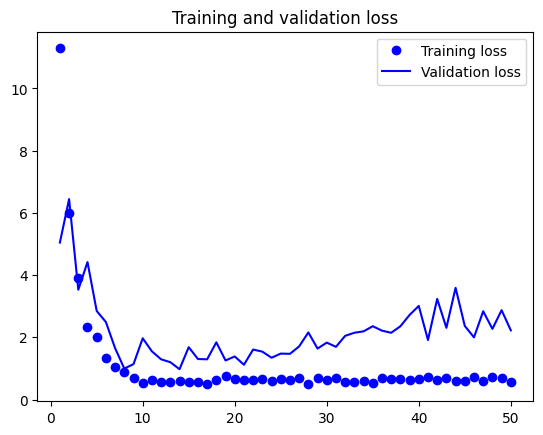

In [65]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

## Evaluating the accuracy of the model on the test dataset

In [66]:
test_model = keras.models.load_model(
    "feature_extraction_with_data_augmentation2")
test_loss, test_acc = test_model.evaluate(test_dataset2)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 1s 32ms/step - loss: 0.6307 - accuracy: 0.9760
Test accuracy: 0.976


Increasing the training sample size from 1,000 images to 3,000 images increased validation accuracy to ~97.0%-98.5% at most and test accuracy to ~97.0%-99.0%. This is the model with the best performance so far.

# Problem #4 Cont: Increasing Training Sample Size to 5,000 images (Still Using Feature Extraction)

## Establishing and freezing the VGG16 convolutional base

In [67]:
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)
conv_base.trainable = False

## Adding a data augmentation stage and a classifier to the initial convolutional base; reference correct training/validation/test datasets

In [68]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [69]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction_with_data_augmentation3",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset3,
    epochs=50,
    validation_data=validation_dataset3,
    callbacks=callbacks)

Epoch 1/50
313/313 [==============================] - 16s 46ms/step - loss: 10.1546 - accuracy: 0.9311 - val_loss: 5.0479 - val_accuracy: 0.9700
Epoch 2/50
313/313 [==============================] - 15s 47ms/step - loss: 4.5032 - accuracy: 0.9516 - val_loss: 1.5729 - val_accuracy: 0.9820
Epoch 3/50
313/313 [==============================] - 12s 37ms/step - loss: 2.4221 - accuracy: 0.9558 - val_loss: 5.5818 - val_accuracy: 0.9220
Epoch 4/50
313/313 [==============================] - 15s 46ms/step - loss: 1.2513 - accuracy: 0.9583 - val_loss: 0.4711 - val_accuracy: 0.9690
Epoch 5/50
313/313 [==============================] - 14s 45ms/step - loss: 0.6911 - accuracy: 0.9598 - val_loss: 0.4053 - val_accuracy: 0.9850
Epoch 6/50
313/313 [==============================] - 15s 47ms/step - loss: 0.6432 - accuracy: 0.9587 - val_loss: 0.3299 - val_accuracy: 0.9790
Epoch 7/50
313/313 [==============================] - 12s 37ms/step - loss: 0.7020 - accuracy: 0.9629 - val_loss: 0.7355 - val_accuracy

## Displaying curves of loss and accuracy during training

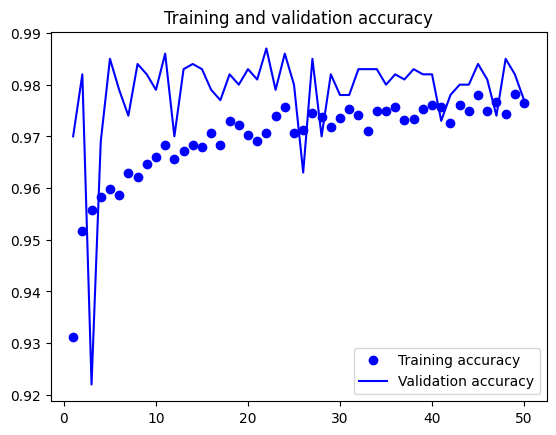

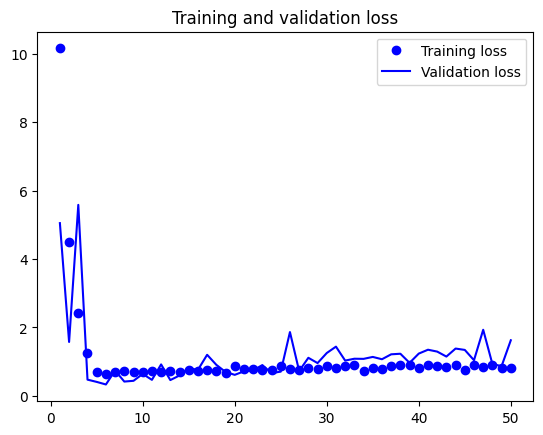

In [70]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

## Evaluating the accuracy of the model on the test dataset

In [71]:
test_model = keras.models.load_model(
    "feature_extraction_with_data_augmentation3")
test_loss, test_acc = test_model.evaluate(test_dataset3)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 1s 31ms/step - loss: 0.4947 - accuracy: 0.9710
Test accuracy: 0.971


Increasing the training sample size to 5,000 images kept validation accuracy around ~97.5%-98.5% at most and test accuracy to ~97.0%-98.5%. However, similar to when I trained the model from scratch using 5,000 images, there are strange trends displayed on the training and validation accuracy and loss plots: validation accuracy is consistently higher than training accuracy, and both training and validation loss are very low. Given these strange trends, I believe increasing the training sample to 5,000 images (or more) isn't the best approach.

# Problem #4 Cont: Decreasing Training Sample Size to 2,000 images (Still Using Feature Extraction)

## Establishing and freezing the VGG16 convolutional base

In [72]:
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)
conv_base.trainable = False

## Adding a data augmentation stage and a classifier to the initial convolutional base; reference correct training/validation/test datasets

In [73]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [74]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction_with_data_augmentation4",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset4,
    epochs=50,
    validation_data=validation_dataset4,
    callbacks=callbacks)

Epoch 1/50
125/125 [==============================] - 10s 68ms/step - loss: 17.2339 - accuracy: 0.9175 - val_loss: 6.6615 - val_accuracy: 0.9630
Epoch 2/50
125/125 [==============================] - 5s 42ms/step - loss: 7.2482 - accuracy: 0.9477 - val_loss: 7.7124 - val_accuracy: 0.9530
Epoch 3/50
125/125 [==============================] - 8s 62ms/step - loss: 5.4922 - accuracy: 0.9503 - val_loss: 5.2653 - val_accuracy: 0.9640
Epoch 4/50
125/125 [==============================] - 5s 43ms/step - loss: 4.3017 - accuracy: 0.9615 - val_loss: 6.4466 - val_accuracy: 0.9660
Epoch 5/50
125/125 [==============================] - 8s 62ms/step - loss: 3.5097 - accuracy: 0.9635 - val_loss: 5.0603 - val_accuracy: 0.9690
Epoch 6/50
125/125 [==============================] - 9s 71ms/step - loss: 2.9231 - accuracy: 0.9682 - val_loss: 2.9604 - val_accuracy: 0.9710
Epoch 7/50
125/125 [==============================] - 5s 43ms/step - loss: 2.5189 - accuracy: 0.9675 - val_loss: 4.0731 - val_accuracy: 0.96

## Displaying curves of loss and accuracy during training

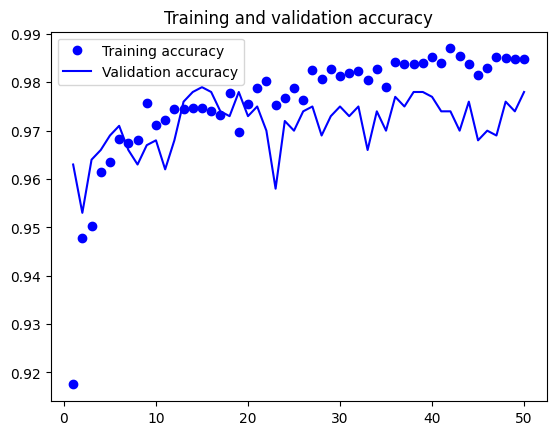

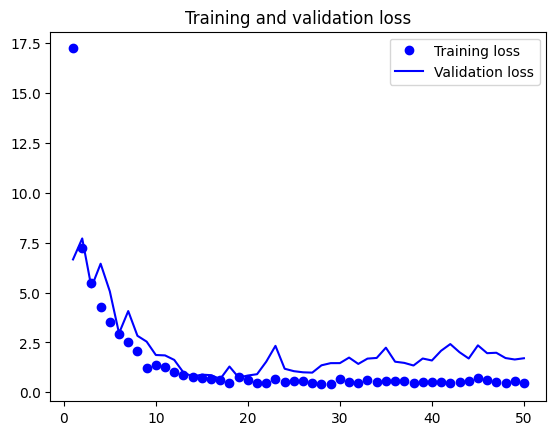

In [75]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

## Evaluating the accuracy of the model on the test dataset

In [76]:
test_model = keras.models.load_model(
    "feature_extraction_with_data_augmentation4")
test_loss, test_acc = test_model.evaluate(test_dataset4)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 1s 32ms/step - loss: 0.3708 - accuracy: 0.9880
Test accuracy: 0.988


Decreasing the training sample size to 2,000 images produces a validation accuracy of ~97.0%-98.0% at most and a test accuracy of ~97.0% - 98.5%. This is overall slightly worse than the pretrained model that used a training sample size of 3,000 images.

# Problem #4 Cont: Fine-Tuning a Pretrained Model using a Training Sample Size of 3,000 images

Since I've been using feature extraction of pretrained models up until now, I'm going to also see if taking the approach of fine-tuning a pretrained model improves performance. I'm going to work with a training sample size of 3,000 images since that produced the best results when both training from scratch and using feature extraction of a pretrained model.

## Freezing all layers until the fourth from the last

In [77]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

## Fine-tuning the model (using training sample size of 3,000)

In [78]:
model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="fine_tuning",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset2,
    epochs=30,
    validation_data=validation_dataset2,
    callbacks=callbacks)

Epoch 1/30
188/188 [==============================] - 13s 58ms/step - loss: 0.9984 - accuracy: 0.9767 - val_loss: 1.8399 - val_accuracy: 0.9790
Epoch 2/30
188/188 [==============================] - 8s 43ms/step - loss: 0.6078 - accuracy: 0.9792 - val_loss: 1.8605 - val_accuracy: 0.9750
Epoch 3/30
188/188 [==============================] - 11s 57ms/step - loss: 0.4886 - accuracy: 0.9805 - val_loss: 1.2488 - val_accuracy: 0.9820
Epoch 4/30
188/188 [==============================] - 11s 61ms/step - loss: 0.3381 - accuracy: 0.9845 - val_loss: 1.1824 - val_accuracy: 0.9820
Epoch 5/30
188/188 [==============================] - 8s 43ms/step - loss: 0.2835 - accuracy: 0.9850 - val_loss: 1.3133 - val_accuracy: 0.9810
Epoch 6/30
188/188 [==============================] - 8s 43ms/step - loss: 0.2721 - accuracy: 0.9865 - val_loss: 1.2337 - val_accuracy: 0.9790
Epoch 7/30
188/188 [==============================] - 8s 43ms/step - loss: 0.2551 - accuracy: 0.9855 - val_loss: 1.2002 - val_accuracy: 0.9

## Displaying curves of loss and accuracy during training

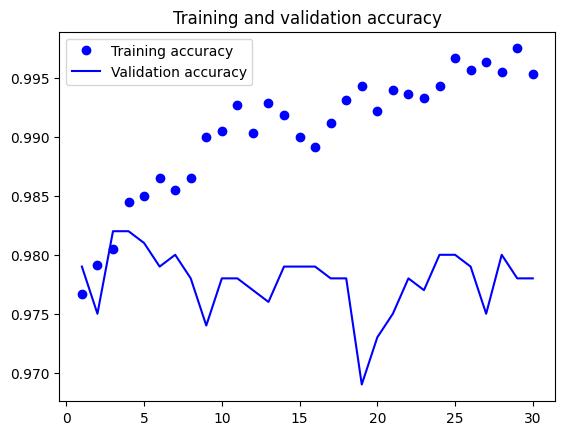

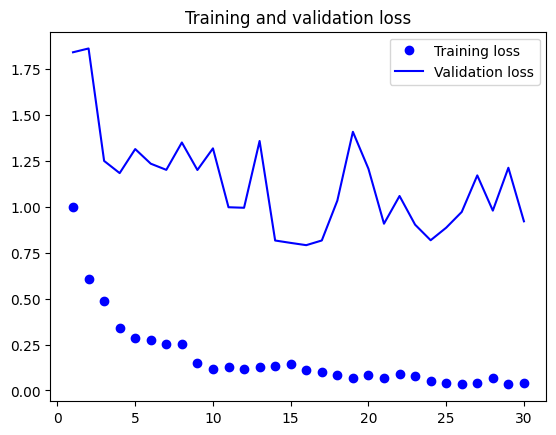

In [79]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

## Evaluating the accuracy of the model on the test dataset

In [80]:
model = keras.models.load_model("fine_tuning")
test_loss, test_acc = model.evaluate(test_dataset2)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 1s 31ms/step - loss: 0.5966 - accuracy: 0.9810
Test accuracy: 0.981


Fine-tuning the pre-trained model using a training sample size of 3,000 images results in a validation accuracy of ~97.5%-98.3% at best and a test accuracy of ~97.0%-98.0%. The training and validation accuracy plot depicts somewhat erratic validation accuracy that frequently drops and increases. Additionally, training accuracy is significantly higher than the validation accuracy. Lastly, the training and validation loss plot also depicts a concerning trend: the validation loss is consistently above 1 and even spikes above 1.5. Given these patterns, fine-tuning the model didn't improve performance, although there are more parameters that would need to be adjusted before entirely ruling out the fine-tuning approach.


# Conclusion

In [81]:
import pandas

In [82]:
data_models = [['From Scratch', 1000, 'No', 'No', '70.0% -75.0%', '65.0% - 72.0%'], ['From Scratch', 1000, 'Yes', 'Yes', '80.0% - 85.0%', '79.0% - 83.0%'], ['From Scratch', 3000, 'No', 'No', '78.0% - 82.0%', '78.0% - 82.0%'], ['From Scratch', 3000, 'Yes', 'Yes', '90.0% - 92.0%', '89.0% - 92.0%'], ['From Scratch', 5000, 'Yes', 'Yes', '91.0% - 94.0%', '90.0% - 92.0%'], ['From Scratch', 2000, 'Yes', 'Yes', '87.0% - 91.0%', '90.0% - 92.0%'], ['Pretrain - Feature', 1000, 'Yes', 'No', '~98.0%', 'NA'], ['Pretrain - Feature', 1000, 'Yes', 'Yes', '~98.0%', '96.0% - 98.0%'], ['Pretrain - Feature', 3000, 'Yes', 'Yes', '97.0% - 98.5%', '97.0% - 99.0%'], ['Pretrain - Feature', 5000, 'Yes', 'Yes', '97.5% - 98.5%', '97.0% - 98.5%'], ['Pretrain - Feature', 2000, 'Yes', 'Yes', '97.0% - 98.0%', '97.0% - 98.5%'], ['Pretrain - Fine-tune', 3000, 'Yes', 'Yes', '97.5% - 98.3%', '97.0% - 98.0%']]

In [83]:
df = pandas.DataFrame(data_models, index=[1,2,3,4,5,6,7,8,9,10,11,12], columns=['Network Type', 'Training Sample Size', 'Dropout Used?', 'Data Augment Used?', 'Validation Accuracy', 'Test Accuracy'])
print(df)

            Network Type  Training Sample Size Dropout Used?  \
1           From Scratch                  1000            No   
2           From Scratch                  1000           Yes   
3           From Scratch                  3000            No   
4           From Scratch                  3000           Yes   
5           From Scratch                  5000           Yes   
6           From Scratch                  2000           Yes   
7     Pretrain - Feature                  1000           Yes   
8     Pretrain - Feature                  1000           Yes   
9     Pretrain - Feature                  3000           Yes   
10    Pretrain - Feature                  5000           Yes   
11    Pretrain - Feature                  2000           Yes   
12  Pretrain - Fine-tune                  3000           Yes   

   Data Augment Used? Validation Accuracy  Test Accuracy  
1                  No        70.0% -75.0%  65.0% - 72.0%  
2                 Yes       80.0% - 85.0%  79.0% 

## In conclusion, the pretrained model using feature extraction and a training sample size of 3,000 images overall performed the best. It appears that increasing the training sample size, up to a certain point, increases the model performance, whether a network is being trained from scratch or a pretrained network is being utilized. The threshold seems to be 3,000 images when keeping the validation and test datasets at 500 images each. The models that used the smallest training sample size (1,000 images) had the worst performance, which implies that the training sample needs to be large enough in order to promote effective learning.

## Additionally, utilizing a pretrained model improved model performance over training a model from scratch. This makes sense given the pretrained model I worked from was trained on a dataset of animal pictures that included several cat and dog pictures. Lastly, utilizing both dropout and data augmentation helped reduce overfitting and improved model performance across both networks trained from scratch and pretrained networks.